<a href="https://colab.research.google.com/github/WeAreDobby/CV_project/blob/main/ConvolutionalAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Google Drive 연동
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from IPython import display

import os
from tqdm import tqdm
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [ ]:
# Load Pocketmon Dataset
def find_path(path):
    file_list = os.listdir(path)
    return file_list

def png_to_np(path, file_list):
    pix = []
    for idx in tqdm(range(len(file_list))):
      file_name = file_list[idx]
      image = PIL.Image.open(path + '/' + file_name)
      np_image = np.array(image).astype(np.float32) / 255.0
      pix.append(np_image)
    return pix

In [ ]:
path = 'drive/MyDrive/dataset/p_dataset'

file_list = find_path(path)

In [ ]:
images = png_to_np(path, file_list)

100%|██████████| 898/898 [00:02<00:00, 379.22it/s]


In [ ]:
train_dataset = np.array(images[:768])
test_dataset = np.array(images[768:])

len(train_dataset), len(test_dataset)

(768, 130)

In [ ]:
train_size = 768
batch_size = 16
test_size = 130

In [ ]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_dataset)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_dataset)
                .shuffle(test_size).batch(batch_size))

In [ ]:
train_dataset, test_dataset

(<BatchDataset shapes: (None, 256, 256, 3), types: tf.float32>,
 <BatchDataset shapes: (None, 256, 256, 3), types: tf.float32>)

In [ ]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(256, 256, 3)),
            
            tf.keras.layers.Conv2D(filters=32, kernel_size=2, strides=(2, 2)),    # 256, 256, 3 -> 128, 128, 32
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Conv2D(filters=64, kernel_size=2, strides=(2, 2)),    # 128, 128, 32 -> 64, 64, 64
            tf.keras.layers.LeakyReLU(),
         
            tf.keras.layers.Conv2D(filters=128, kernel_size=2, strides=(2, 2)),   # 64, 64, 64 -> 32, 32, 128
            tf.keras.layers.LeakyReLU(),
         
            tf.keras.layers.Conv2D(filters=256, kernel_size=2, strides=(2, 2)),   # 32, 32, 128 -> 16, 16, 256
            tf.keras.layers.LeakyReLU(),
         
            tf.keras.layers.Conv2D(filters=512, kernel_size=2, strides=(2, 2)),   # 16, 16, 256 -> 8, 8, 512
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Flatten(),                                            # 8, 8, 512 -> 8 * 8 * 512 = 32768
            
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),                       # 32768 -> 4
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            
            tf.keras.layers.Dense(units=8 * 8 * 512),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Reshape(target_shape=(8, 8, 512)),
            
            tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=2, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=2, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=2, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(),
         
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(),
         
            tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=2, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=2, strides=1, padding='same')

        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

NameError: ignored

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
epochs = 500
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [ ]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 500, Test set ELBO: -92158.84375, time elapse for current epoch: 1.2456307411193848


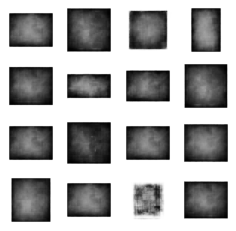

100%|██████████| 500/500 [18:29<00:00,  2.22s/it]


In [ ]:
generate_and_save_images(model, 0, test_sample)

for epoch in tqdm(range(1, epochs + 1)):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

In [ ]:
'''
encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(256, 256, 3)),
            
            tf.keras.layers.Conv2D(filters=32, kernel_size=2, strides=(2, 2)),    # 256, 256, 3 -> 128, 128, 32
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Conv2D(filters=64, kernel_size=2, strides=(2, 2)),    # 128, 128, 32 -> 64, 64, 64
            tf.keras.layers.LeakyReLU(),
         
            tf.keras.layers.Conv2D(filters=128, kernel_size=2, strides=(2, 2)),   # 64, 64, 64 -> 32, 32, 128
            tf.keras.layers.LeakyReLU(),
         
            tf.keras.layers.Conv2D(filters=256, kernel_size=2, strides=(2, 2)),   # 32, 32, 128 -> 16, 16, 256
            tf.keras.layers.LeakyReLU(),
         
            tf.keras.layers.Conv2D(filters=512, kernel_size=2, strides=(2, 2)),   # 16, 16, 256 -> 8, 8, 512
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Flatten(),                                            # 8, 8, 512 -> 8 * 8 * 512 = 32768
            
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),                       # 32768 -> 4
        ]
    )
decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            
            tf.keras.layers.Dense(units=8 * 8 * 512),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Reshape(target_shape=(8, 8, 512)),
            
            tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=2, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=2, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=2, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(),
         
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(),
         
            tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=2, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=2, strides=1, padding='same')
        ]
    )

encoder.summary()
decoder.summary()
'''

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 128, 128, 32)      416       
_________________________________________________________________
leaky_re_lu_115 (LeakyReLU)  (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 64, 64, 64)        8256      
_________________________________________________________________
leaky_re_lu_116 (LeakyReLU)  (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 32, 32, 128)       32896     
_________________________________________________________________
leaky_re_lu_117 (LeakyReLU)  (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 16, 16, 256)     